<a href="https://colab.research.google.com/github/abdulwaheedTMU/Project2/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Data Processing

In [6]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define input image shape and batch size
IMG_HEIGHT, IMG_WIDTH = 500, 500
BATCH_SIZE = 32

# Set up directories
train_dir = '/content/drive/MyDrive/AER-850 /Project 2 Data/Data/train'
validation_dir = '/content/drive/MyDrive/AER-850 /Project 2 Data/Data/valid'
test_dir = '/content/drive/MyDrive/AER-850 /Project 2 Data/Data/test'

# Define augmentation pipeline for training data
train_data_gen = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # Shear-like behavior
    tf.keras.layers.RandomZoom(0.2)  # Zoom augmentation
])

# Rescaling only for validation and test data
val_test_data_gen = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

# Create training dataset
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",  # Multi-class classification
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
).map(lambda x, y: (train_data_gen(x), y))  # Apply augmentation pipeline

# Create validation dataset
validation_dataset = image_dataset_from_directory(
    validation_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
).map(lambda x, y: (val_test_data_gen(x), y))  # Apply rescaling


Mounted at /content/drive
Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.


Step 2: Neural Network Architecture Design

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# 1. Convolutional Layer + Max Pooling Layer
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(500, 500, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# 2. Add a second Convolutional Layer + Max Pooling Layer
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# 3. Add a third Convolutional Layer + Max Pooling Layer
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# 4. Flatten the output
model.add(layers.Flatten())

# 5. Fully Connected (Dense) Layer with Dropout
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

# 6. Output Layer
model.add(layers.Dense(3, activation='softmax'))  # 3 neurons for 3 classes

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 498, 498, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 247, 247, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 123, 123, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 121, 121, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 460800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      58,982,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,076,163 (225.36 MB)

 Trainable params: 59,076,163 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

Pipeline Visualization and Architecture Visualization

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


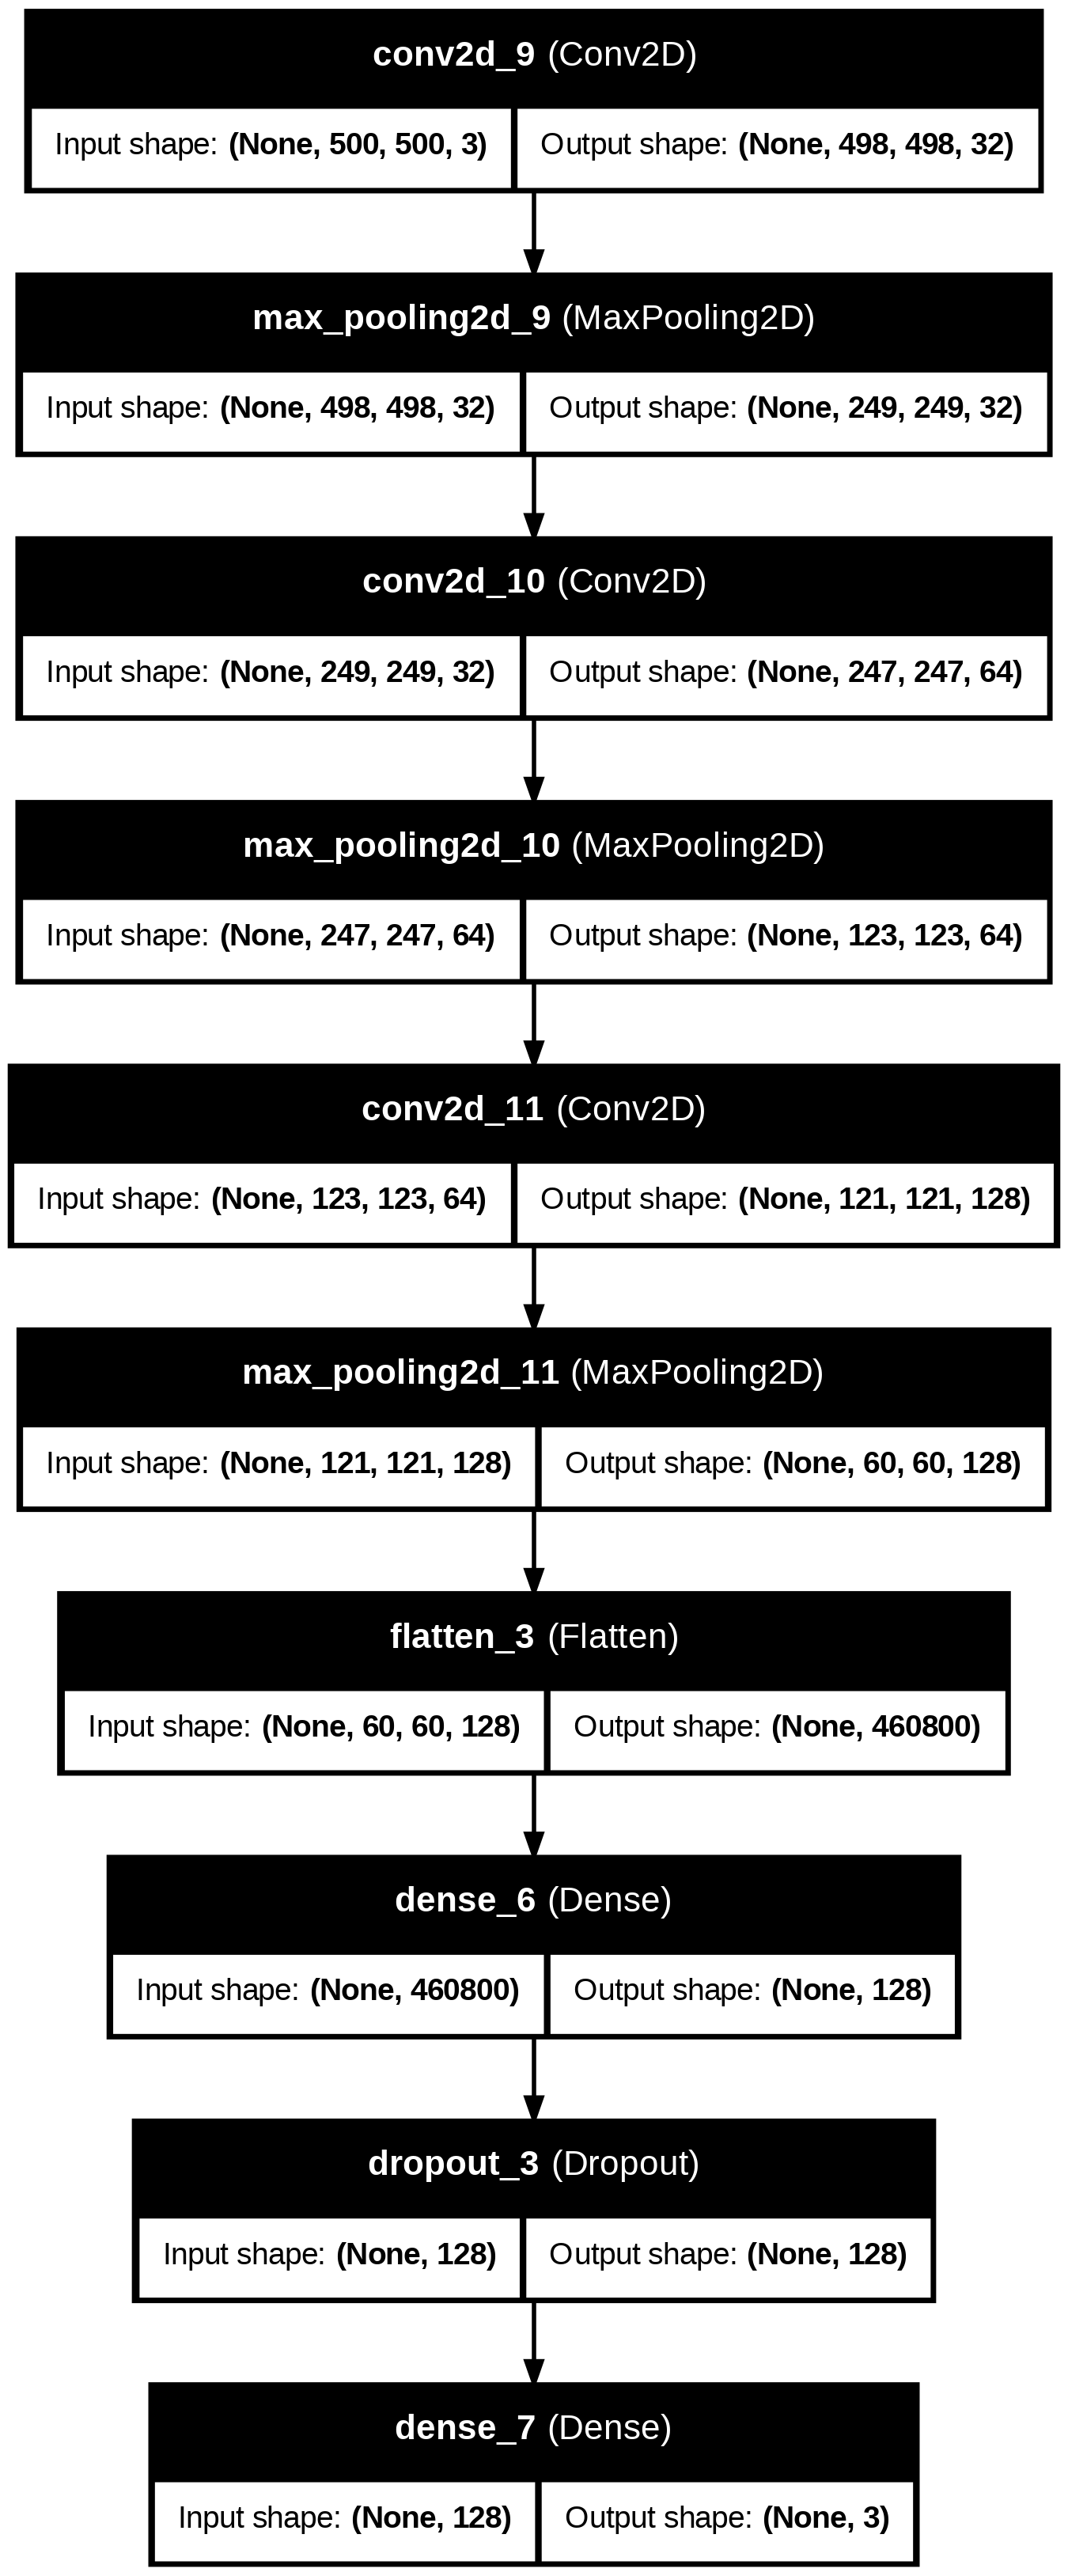

In [8]:
from graphviz import Digraph
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

# --- Data Processing Pipeline Visualization ---
# Create a graph for the data pipeline
dot = Digraph(comment='Data Processing Pipeline', format='png')

# Add nodes for directories
dot.node('A', 'Train Directory')
dot.node('B', 'Validation Directory')
dot.node('C', 'Test Directory')

# Add nodes for processing
dot.node('D', 'Augmentation (Rescaling, Shear, Zoom)')
dot.node('E', 'Rescaling')
dot.node('F', 'Rescaling')

# Add model input
dot.node('G', 'Model Input')

# Connect nodes
dot.edges(['AD', 'BE', 'CF'])
dot.edge('D', 'G')
dot.edge('E', 'G')
dot.edge('F', 'G')

# Render the graph
dot.render('data_pipeline', view=True)

# --- Model Architecture Visualization ---
# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes for output
])

# Save the model visualization
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,  # Display layer shapes
    show_layer_names=True  # Display layer names
)


Step 3: Hyperparameter Analysis

In [9]:
from tensorflow.keras import layers, models, optimizers

# Define model with tunable hyperparameters
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation=None, input_shape=(500, 500, 3)),  # No activation here
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU activation
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),  # Standard ReLU for comparison
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='elu'),  # ELU for dense layer
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Softmax for final layer
])

# Compile with a different optimizer (e.g., RMSprop)
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 348s 5s/step - accuracy: 0.3342 - loss: 9.3745 - val_accuracy: 0.4060 - val_loss: 3.1944
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.3703 - loss: 1.3877 - val_accuracy: 0.4060 - val_loss: 4.5706
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.4267 - loss: 1.4011 - val_accuracy: 0.4455 - val_loss: 1.0544
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4305 - loss: 1.1505 - val_accuracy: 0.5429 - val_loss: 0.9558
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4591 - loss: 1.1464 - val_accuracy: 0.5220 - val_loss: 0.9751
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.4900 - loss: 1.0463 - val_accuracy: 0.3527 - val_loss: 1.1391
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.4625 - loss: 1.0820 - val_accuracy: 0.5684 - val_loss: 0.9753
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.5056 - loss: 1.0276 - val_accuracy: 0.5708 - val_loss: 0.